<h4>How to build a document classifier ? </h4>
Problem:

We want to build a model that is able to tell if a Pubmed article is refering to child or adult patient(s).

Solution:

We construct a training/validation set out of English only Pubmed articles and use the keywords associated with these articles to assign the labels.

Using Keras with Tensorflow backend, we train a convolutional neural network on the training data. We show very good accuracy and f1-score can be obtained in 5 Epochs.

http://biopython.org/DIST/docs/tutorial/Tutorial.html

In [1]:
from __future__ import print_function
search_term = 'type+1+diabetes[MH]'
max_articles = 10000

from Bio import Entrez
print('Searching PubMed abstracts for documents containing term: ',search_term)
handle = Entrez.esearch(db="pubmed", term=search_term, retmax=max_articles)
record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]

print('Found:',len(idlist),' documents')

Searching PubMed abstracts for documents containing term:  type+1+diabetes[MH]
Found: 10000  documents


In [2]:
#fetching the previously found documents
#select only English articles 
#assign labels based on the keywords assoociated with the articles
from Bio import Medline
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline",retmode="text")
records = Medline.parse(handle)
data = []
adults =0
child =0
for record in records:
    if 'AB' not in record or record['AB'] is None:
        continue
    if len(record['LA'])==1 and record['LA'][0]=='eng':
        is_adult = False
        is_child = False
        for val in record['MH']:
            if val =='Adult':
                is_adult=True
                break
            if val =='Adolescent' or val=='Child':
                is_child=True
        if is_adult and is_child:
            continue
        if is_adult:
            adults+=1
            data.append((record,1))
        if is_child:
            data.append((record,0))
            child+=1
print ('Articles about adults:',adults,'  Articles about children/child:',child)

Articles about adults: 2005   Articles about children/child: 1580


In [3]:
#Dump the obtained data to disk in case we need to repeat the process from here on.
import dill as pickle
with open('pubmed_records.tmp','w') as f:
    pickle.dump(data,f)
# pickle.load(f)

In [4]:
#Split the data into trianing/test sets
split=0.8
train_set = data[:int(split*len(data))]
test_set = data[int(split*len(data)):]

In [5]:
#separate labels 
x_train = [record[0].get('AB') for record in train_set]
y_train = [record[1] for record in train_set]
x_test = [record[0].get('AB') for record in test_set]
y_test = [record[1] for record in test_set]

from keras.preprocessing.text import hashing_trick

max_features = 5000
#Transform the input articles into number sequences by replacing each word
#with it's index in a frequency list

x_train = [hashing_trick(record,max_features) for record in x_train]
x_test = [hashing_trick(record,max_features) for record in x_test]


Using TensorFlow backend.


In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

# set parameters for our model:
maxlen = 1000 #max 1000 words per article
batch_size = 32 #size of the batch 
embedding_dims = 50 # size of the embedding vectors for each word
filters = 250 #dimension of filters for the convolutional layer
kernel_size = 3 #size of the kernel used in the convolutional layer
hidden_dims = 250 #dimension of the hidden layer
epochs = 5 #number of training epochs

In [7]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

2868 train sequences
717 test sequences
Pad sequences (samples x time)
x_train shape: (2868, 1000)
x_test shape: (717, 1000)


In [8]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen
                   ))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Build model...
Train on 2868 samples, validate on 717 samples
Epoch 1/5
2868/2868 [==============================] - 32s - loss: 0.6252 - acc: 0.6496 - f1: 0.7627 - val_loss: 0.3850 - val_acc: 0.8424 - val_f1: 0.8723
Epoch 2/5
2868/2868 [==============================] - 34s - loss: 0.2890 - acc: 0.8856 - f1: 0.9008 - val_loss: 0.2575 - val_acc: 0.8954 - val_f1: 0.9071
Epoch 3/5
2868/2868 [==============================] - 34s - loss: 0.1825 - acc: 0.9264 - f1: 0.9346 - val_loss: 0.2379 - val_acc: 0.9010 - val_f1: 0.9126
Epoch 4/5
2868/2868 [==============================] - 33s - loss: 0.0983 - acc: 0.9658 - f1: 0.9684 - val_loss: 0.2756 - val_acc: 0.9024 - val_f1: 0.9160
Epoch 5/5
2868/2868 [==============================] - 34s - loss: 0.0371 - acc: 0.9899 - f1: 0.9900 - val_loss: 0.2975 - val_acc: 0.8884 - val_f1: 0.9009


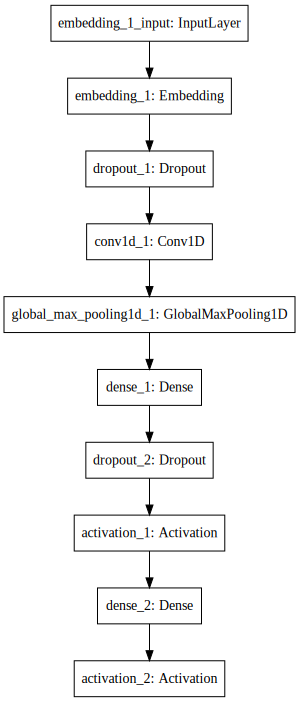

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy',f1])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print('Performance of loaded model on the test-set:')
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

Performance of loaded model on the test-set:
acc: 88.84%
f1: 90.09%
